In [3]:
import numpy as np
import pandas as pd
import time
from datasets import load_dataset
from transformers import get_cosine_schedule_with_warmup
from tqdm import notebook

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
dataset = load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')
df = dataset['train'].to_pandas()
df.describe()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/ucberkeley-dlab--measuring-hate-speech-2d735043be36d4ff/0.0.0/0b6d5799bb726b24ad7fc7be720c170d8e497f575d02d47537de9a5bac074901. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,hatespeech,hate_speech_score,infitms,outfitms,annotator_severity,std_err,annotator_infitms,annotator_outfitms,hypothesis,annotator_age
count,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.00000,135556.000000,135556.000000,135556.000000,135556.000000,...,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135556.000000,135451.000000
mean,23530.416138,5567.097812,1.281352,2.954307,2.828875,2.56331,2.278638,2.698575,1.846211,1.052045,...,0.744733,-0.567428,1.034322,1.001052,-0.018817,0.300588,1.007158,1.011841,0.014589,37.910772
std,12387.194125,3230.508937,1.023542,1.231552,1.309548,1.38983,1.370876,0.898500,1.402372,1.345706,...,0.932260,2.380003,0.496867,0.791943,0.487261,0.236380,0.269876,0.675863,0.613006,11.641276
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-8.340000,0.100000,0.070000,-1.820000,0.020000,0.390000,0.280000,-1.578693,18.000000
25%,18148.000000,2719.000000,0.000000,2.000000,2.000000,2.00000,1.000000,2.000000,1.000000,0.000000,...,0.000000,-2.330000,0.710000,0.560000,-0.380000,0.030000,0.810000,0.670000,-0.341008,29.000000
50%,20052.000000,5602.500000,1.000000,3.000000,3.000000,3.00000,3.000000,3.000000,2.000000,0.000000,...,0.000000,-0.340000,0.960000,0.830000,-0.020000,0.340000,0.970000,0.850000,0.110405,35.000000
75%,32038.250000,8363.000000,2.000000,4.000000,4.000000,4.00000,3.000000,3.000000,3.000000,2.000000,...,2.000000,1.410000,1.300000,1.220000,0.350000,0.420000,1.170000,1.130000,0.449555,45.000000
max,50070.000000,11142.000000,3.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,...,2.000000,6.300000,5.900000,9.000000,1.360000,1.900000,2.010000,9.000000,0.987511,81.000000


In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['comment_id', 'annotator_id', 'platform', 'sentiment', 'respect', 'insult', 'humiliate', 'status', 'dehumanize', 'violence', 'genocide', 'attack_defend', 'hatespeech', 'hate_speech_score', 'text', 'infitms', 'outfitms', 'annotator_severity', 'std_err', 'annotator_infitms', 'annotator_outfitms', 'hypothesis', 'target_race_asian', 'target_race_black', 'target_race_latinx', 'target_race_middle_eastern', 'target_race_native_american', 'target_race_pacific_islander', 'target_race_white', 'target_race_other', 'target_race', 'target_religion_atheist', 'target_religion_buddhist', 'target_religion_christian', 'target_religion_hindu', 'target_religion_jewish', 'target_religion_mormon', 'target_religion_muslim', 'target_religion_other', 'target_religion', 'target_origin_immigrant', 'target_origin_migrant_worker', 'target_origin_specific_country', 'target_origin_undocumented', 'target_origin_other', 'target_origin', 'target_gender_men', 'target

In [6]:
len(df['comment_id'].unique())

39565

In [7]:
len(df['annotator_id'].unique())

7912

In [8]:
df.head()

,comment_id,annotator_id,platform,sentiment,respect,insult,humiliate,status,dehumanize,violence,...,annotator_religion_hindu,annotator_religion_jewish,annotator_religion_mormon,annotator_religion_muslim,annotator_religion_nothing,annotator_religion_other,annotator_sexuality_bisexual,annotator_sexuality_gay,annotator_sexuality_straight,annotator_sexuality_other
0,47777,10873,3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
1,39773,2790,2,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
2,47101,3379,3,4.0,4.0,4.0,4.0,4.0,4.0,0.0,...,False,False,False,False,True,False,False,False,True,False
3,43625,7365,3,2.0,3.0,2.0,1.0,2.0,0.0,0.0,...,False,False,False,False,False,False,False,False,True,False
4,12538,488,0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,...,False,False,False,False,False,False,False,False,True,False


In [9]:
df[df['comment_id'] == 43625][['hate_speech_score', 'hatespeech']]

,hate_speech_score,hatespeech
3,0.26,0.0
24412,0.26,0.0
49310,0.26,2.0
70100,0.26,0.0


<Axes: >

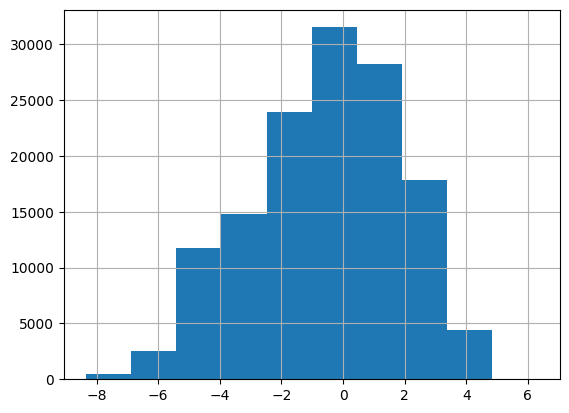

In [10]:
df['hate_speech_score'].hist()

In [11]:
df['hatespeech'].unique()

array([0., 2., 1.])

In [12]:
df[df['comment_id'] == 47101]['hate_speech_score']

2        0.36
25182    0.36
46708    0.36
69660    0.36
Name: hate_speech_score, dtype: float64

In [13]:
def get_agreement_score(x):
    mode_result = x.mode()
    mode_count = (x == mode_result.iloc[0]).sum()
    ln = len(x)
    
    return round(mode_count/ln*5)/5

In [14]:
text_df = df.groupby('comment_id', as_index=False).agg({'text': 'first', 'hate_speech_score': 'first', 'hatespeech': get_agreement_score})
text_df.columns = ['comment_id', 'text', 'hate_speech_score', 'annotator_agreement_factor']
text_df.head()

,comment_id,text,hate_speech_score,annotator_agreement_factor
0,1,White people are trash.,0.46,1.0
1,2,"You've caught the big gay, it's known to be ai...",0.03,0.6
2,3,"I'm not saying you said that, I'm just saying ...",-1.29,0.6
3,4,Donald Trump. Yeet myself off a building onto ...,-0.24,0.4
4,5,Fabrice Fabrice is ostensibly black or black/l...,-2.84,1.0


In [15]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39565 entries, 0 to 39564
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   comment_id                  39565 non-null  int32  
 1   text                        39565 non-null  object 
 2   hate_speech_score           39565 non-null  float64
 3   annotator_agreement_factor  39565 non-null  float64
dtypes: float64(2), int32(1), object(1)
memory usage: 1.1+ MB


In [16]:
def score_to_label(score):
  if score < -1:
    return 0
  if score > 0.5:
    return 2
  return 1

In [17]:
text_df['label'] = text_df['hate_speech_score'].apply(lambda x:score_to_label(x))
text_df.head()

,comment_id,text,hate_speech_score,annotator_agreement_factor,label
0,1,White people are trash.,0.46,1.0,1
1,2,"You've caught the big gay, it's known to be ai...",0.03,0.6,1
2,3,"I'm not saying you said that, I'm just saying ...",-1.29,0.6,0
3,4,Donald Trump. Yeet myself off a building onto ...,-0.24,0.4,1
4,5,Fabrice Fabrice is ostensibly black or black/l...,-2.84,1.0,0


<Axes: >

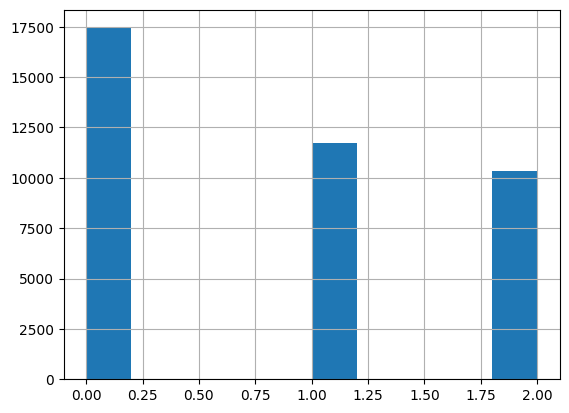

In [18]:
text_df['label'].hist()

<Axes: >

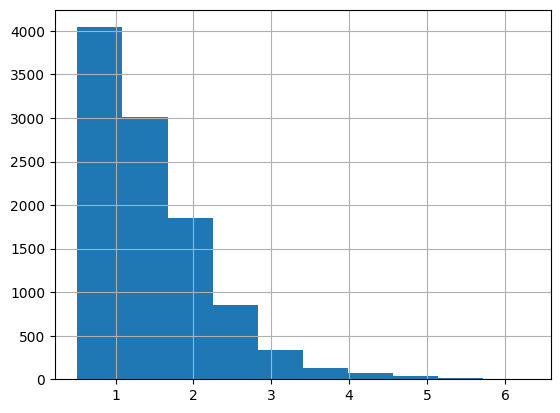

In [32]:
text_df[text_df['label'] == 2]['hate_speech_score'].hist()

In [20]:
import os
import random

In [21]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

In [22]:
SEED = 9875
seed_everything(SEED)

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: ', device.type)

Device:  cuda


In [24]:
BERT = 'bert-base-uncased'
ROBERTA = 'roberta-base'

In [25]:
MODEL_NAME = ROBERTA

In [26]:
from sklearn.model_selection import StratifiedKFold, train_test_split

In [27]:
X_train, X_temp, y_train, y_temp = train_test_split(text_df[['comment_id', 'text']], text_df.label, test_size=0.2, random_state=SEED, stratify=text_df.label)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

In [28]:
print(X_train.shape, y_train.shape)

(31652, 2) (31652,)


In [29]:
train_df = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
val_df = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
test_df = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

In [28]:
# train_df_0 = train_df[train_df['label'] == 0].sample(frac=0.3)
# train_df_1 = train_df[train_df['label'] == 1].sample(frac=0.3)
# train_df_2 = train_df[train_df['label'] == 2].sample(frac=0.3)
# train_df = pd.concat([train_df_0, train_df_1, train_df_2], axis=0).reset_index(drop=True)
# len(train_df)

In [33]:
train_df.head()

,comment_id,text,label
0,13686,"""Equal pay"", here we go with this bull crap ag...",2
1,34378,@DebatingHipHop_ you no mustache having With w...,2
2,47745,@BIG A That's a nice fake mustache you have th...,1
3,4600,Basically this. Us Brits will use anything as ...,2
4,33091,Southwest Airlines Celebrates LGBT Pride Month...,0


In [34]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [45]:
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
MAX_LEN = 256
EPOCHS = 3
LEARNING_RATE = 5e-5
NUM_LABELS = 3

In [46]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.len = len(df)
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        text = self.df.loc[index, 'text']
        text_id = self.df.loc[index, 'comment_id']
        inputs = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_len,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        if MODEL_NAME=='bert-base-uncased':
            token_type_ids = inputs['token_type_ids']
        else:
            token_type_ids = 1.

        target = self.df.loc[index, 'label']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'masks': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(target, dtype=torch.long),
            'text_ids': text_id
        }

    def __len__(self):
        return self.len


In [47]:
train_data = TextDataset(train_df, tokenizer, MAX_LEN)
val_data = TextDataset(val_df, tokenizer, MAX_LEN)
test_data = TextDataset(test_df, tokenizer, MAX_LEN)

In [48]:
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

valid_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'num_workers': 0
}

train_loader = DataLoader(train_data, **train_params)
val_loader = DataLoader(val_data, **valid_params)
test_loader = DataLoader(test_data, **test_params)

In [49]:
class HateSpeechClassifier(torch.nn.Module):
    def __init__(self, model_name, dropout=True):
        super(HateSpeechClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.model_name = model_name

        if model_name == BERT:
            self.in_features = self.bert.pooler.dense.out_features
        elif model_name == ROBERTA:
            self.in_features = self.bert.pooler.dense.out_features
        else:
            self.in_features = 768

        self.dense = nn.Linear(self.in_features, 64)
        self.activation = nn.ReLU()
#         self.layer_norm = nn.LayerNorm(self.in_features)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(64, NUM_LABELS)

    def forward(self, input_ids, attention_mask, token_type_ids):
        if self.model_name == BERT:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  token_type_ids=token_type_ids,
                                                  return_dict=False)
        elif self.model_name == ROBERTA:
            last_hidden_state, output = self.bert(input_ids,
                                                  attention_mask=attention_mask,
                                                  return_dict=False)

        output = self.dense(output)
        output = self.activation(output)
#         output = self.layer_norm(output)
        output = self.dropout(output)
        output = self.classifier(output)
        # output = torch.nn.Softmax(output)
        return output

In [58]:
model = HateSpeechClassifier(MODEL_NAME)
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


HateSpeechClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [59]:
num_training_steps = EPOCHS*len(train_loader)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)
num_warmup_steps = 100
scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_training_steps=num_training_steps,
    num_warmup_steps=num_warmup_steps,
)

In [60]:
def calc_accuracy(preds, targets):
    accuracy = (preds==targets).cpu().numpy().mean() * 100
    return accuracy

In [61]:
def train(model, loss_fn, train_dataloader, val_dataloader=None, epochs=5, evaluation=False):

    print("Training...\n")
    train_values = []
    for epoch in range(epochs):
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        train_loss = []
        model.train()

        epoch_train_values = torch.empty(0, dtype=torch.float)

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            model.zero_grad()
            input_ids = batch['ids'].to(device, dtype = torch.long)
            attention_mask = batch['masks'].to(device, dtype = torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
            targets = batch['targets'].to(device, dtype = torch.long)

            text_ids = batch['text_ids'].unsqueeze(1)

            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            train_loss.append(loss.item())

            batch_loss += loss.item()
            total_loss += loss.item()

            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            softmax_values = torch.nn.functional.softmax(outputs, dim=1)

            batch_train_values = torch.cat((text_ids, softmax_values.cpu()), dim=1)
            epoch_train_values = torch.cat((epoch_train_values, batch_train_values), dim = 0)

            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)

        print("-"*70)

        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, loss_fn, val_dataloader)
            time_elapsed = time.time() - t0_epoch

            print(f"{epoch + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")

            print("-"*70)

        train_values.append(epoch_train_values)
        print("\n")

    print("Training complete!")
    return train_values


In [62]:
def evaluate(model, loss_fn, val_dataloader):
    model.eval()

    val_accuracy = []
    val_loss = []

    for batch in val_dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        val_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        val_accuracy.append(calc_accuracy(max_ids, targets))

    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [98]:
def predict(model, loss_fn, dataloader):
    model.eval()

    test_accuracy = []
    test_loss = []
    test_preds = []

    for batch in dataloader:
        input_ids = batch['ids'].to(device, dtype = torch.long)
        attention_mask = batch['masks'].to(device, dtype = torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype = torch.long)
        targets = batch['targets'].to(device, dtype = torch.long)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask, token_type_ids)

        loss = loss_fn(outputs, targets)
        test_loss.append(loss.item())

        _, max_ids = torch.max(outputs.data, dim=1)
        test_accuracy.append(calc_accuracy(max_ids, targets))
        test_preds.append([max_ids.cpu().detach().numpy().reshape(-1), targets.cpu().detach().numpy().reshape(-1)])

    test_loss = np.mean(test_loss)
    test_accuracy = np.mean(test_accuracy)

    return test_loss, test_accuracy, test_preds

In [63]:
train_values = train(model, loss_function, train_loader, val_loader, epochs=EPOCHS, evaluation=True)

Training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   1.137743   |     -      |     -     |   15.98  
   1    |   40    |   1.093995   |     -      |     -     |   15.15  
   1    |   60    |   0.995367   |     -      |     -     |   15.18  
   1    |   80    |   0.906480   |     -      |     -     |   15.20  
   1    |   100   |   0.893280   |     -      |     -     |   15.23  
   1    |   120   |   0.890278   |     -      |     -     |   15.24  
   1    |   140   |   0.845616   |     -      |     -     |   15.27  
   1    |   160   |   0.806905   |     -      |     -     |   15.27  
   1    |   180   |   0.828865   |     -      |     -     |   15.28  
   1    |   200   |   0.836855   |     -      |     -     |   15.27  
   1    |   220   |   0.821267   |     -      |     -     |   15.28  
   1    |   240   |   0.845560   |     -      |     -     |   15.23  
   1  

In [99]:
test_loss, test_accuracy, test_preds = predict(model, loss_function, test_loader)
test_loss, test_accuracy

(0.7679390126178341, 67.87514400921658)

In [117]:
preds = []
targets = []
for ele in test_preds:
    for p in ele[0]: preds.append(p)
    for p in ele[1]: targets.append(p)

preds_np = np.array(preds)
targets_np = np.array(targets)
print(preds_np.shape, targets_np.shape)

(3957,) (3957,)


In [122]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [129]:
print(f1_score(targets_np, preds_np, average="weighted"))

0.6800941171715521


In [124]:
print(classification_report(targets_np, preds_np,))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      1748
           1       0.51      0.52      0.52      1174
           2       0.69      0.68      0.68      1035

    accuracy                           0.68      3957
   macro avg       0.66      0.66      0.66      3957
weighted avg       0.68      0.68      0.68      3957



In [125]:
print(confusion_matrix(targets_np, preds_np))

[[1368  323   57]
 [ 294  614  266]
 [  60  270  705]]


In [65]:
train_values2 = [0] * len(train_values)
for i, v in enumerate(train_values):
    train_values2[i] = v.cpu().detach().numpy()

In [66]:
train_values3 = []
for i, v in enumerate(train_values2):
    for j, row in notebook.tqdm(enumerate(v)):
        row1 = np.append(row, i+1)
        train_values3.append(row1)
        
train_values_np = np.stack(train_values3, axis=0)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [67]:
train_values_np.shape

(94956, 5)

In [68]:
train_values_df = pd.DataFrame(train_values_np, columns=['comment_id', 'label_0', 'label_1', 'label_2', 'epoch_no'])
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no
0,655.0,0.278869,0.346344,0.374787,1.0
1,34133.0,0.274856,0.349418,0.375726,1.0
2,44389.0,0.275951,0.348146,0.375902,1.0
3,48210.0,0.248612,0.340459,0.410928,1.0
4,14375.0,0.277621,0.342312,0.380067,1.0


In [69]:
train_values_df['comment_id'] = train_values_df['comment_id'].astype(int)
train_values_df['epoch_no'] = train_values_df['epoch_no'].astype(int)
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no
0,655,0.278869,0.346344,0.374787,1
1,34133,0.274856,0.349418,0.375726,1
2,44389,0.275951,0.348146,0.375902,1
3,48210,0.248612,0.340459,0.410928,1
4,14375,0.277621,0.342312,0.380067,1


In [70]:
train_values_df = pd.merge(train_values_df, text_df[['comment_id', 'label', 'hate_speech_score', 'annotator_agreement_factor']], on='comment_id', how='left')
train_values_df.head()

,comment_id,label_0,label_1,label_2,epoch_no,label,hate_speech_score,annotator_agreement_factor
0,655,0.278869,0.346344,0.374787,1,0,-1.42,1.0
1,34133,0.274856,0.349418,0.375726,1,0,-4.12,1.0
2,44389,0.275951,0.348146,0.375902,1,1,-0.15,1.0
3,48210,0.248612,0.340459,0.410928,1,2,1.00,0.4
4,14375,0.277621,0.342312,0.380067,1,0,-2.75,1.0


In [71]:
def get_pred(label_0, label_1, label_2):
    if label_0> label_1 and label_0 > label_2:
        return 0
    elif label_1> label_0 and label_1 > label_2:
        return 1
    else:
        return 2

In [72]:
train_values_df['pred'] = train_values_df.apply(lambda row: get_pred(row.label_0, row.label_1, row.label_2), axis=1)

In [73]:
train_values_df.tail()

,comment_id,label_0,label_1,label_2,epoch_no,label,hate_speech_score,annotator_agreement_factor,pred
94951,5258,0.988349,0.009888,0.001763,3,0,-4.98,1.0,0
94952,33272,0.991370,0.007287,0.001343,3,0,-2.48,1.0,0
94953,9283,0.280883,0.666366,0.052751,3,0,-2.34,1.0,1
94954,10133,0.731808,0.247393,0.020799,3,0,-1.27,1.0,0
94955,45916,0.140078,0.741051,0.118870,3,1,-0.25,1.0,1


In [74]:
train_values_agg_df = train_values_df.sort_values(['epoch_no']).groupby('comment_id', as_index=False).agg({'label_0': ['mean', 'std', 'last'], 'label_1': ['mean', 'std', 'last'], 'label_2': ['mean', 'std', 'last'], 'label': 'first', 'hate_speech_score': 'first', 'pred': 'last', 'annotator_agreement_factor': 'first'})

In [75]:
train_values_agg_df.head()

comment_id   label_0                       label_1                      \
                  mean       std      last      mean       std      last   
0          1  0.037798  0.023002  0.013642  0.266716  0.020818  0.253030   
1          2  0.405674  0.223592  0.159999  0.494651  0.198882  0.721824   
2          3  0.800839  0.297976  0.961469  0.138789  0.201363  0.031826   
3          4  0.370539  0.123381  0.425368  0.424790  0.082166  0.496477   
4          5  0.974841  0.001649  0.972955  0.020781  0.000941  0.020979   

    label_2                     label hate_speech_score pred  \
       mean       std      last first             first last   
0  0.695485  0.033632  0.733329     1              0.46    2   
1  0.099675  0.042739  0.118177     1              0.03    1   
2  0.060372  0.096631  0.006705     0             -1.29    0   
3  0.204672  0.200320  0.078155     1             -0.24    1   
4  0.004378  0.001621  0.006066     0             -2.84    0   

  annotator_agreement_factor  
                       first  
0                        1.0  
1                        0.6  
2                        0.6  
3                        0.4  
4                        1.0

In [76]:
train_values_agg_df.columns = ['comment_id', 'label_0_mean', 'label_0_std', 'label_0_last', 'label_1_mean', 'label_1_std', 'label_1_last', 'label_2_mean', 'label_2_std', 'label_2_last', 'label', 'hate_speech_score', 'pred', 'annotator_agreement_factor']
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor
0,1,0.037798,0.023002,0.013642,0.266716,0.020818,0.253030,0.695485,0.033632,0.733329,1,0.46,2,1.0
1,2,0.405674,0.223592,0.159999,0.494651,0.198882,0.721824,0.099675,0.042739,0.118177,1,0.03,1,0.6
2,3,0.800839,0.297976,0.961469,0.138789,0.201363,0.031826,0.060372,0.096631,0.006705,0,-1.29,0,0.6
3,4,0.370539,0.123381,0.425368,0.424790,0.082166,0.496477,0.204672,0.200320,0.078155,1,-0.24,1,0.4
4,5,0.974841,0.001649,0.972955,0.020781,0.000941,0.020979,0.004378,0.001621,0.006066,0,-2.84,0,1.0


In [77]:
def get_confidence(label, label_0_mean, label_1_mean, label_2_mean):
    if label == 0:
        return label_0_mean
    elif label == 1:
        return label_1_mean
    else: return label_2_mean
    
def get_variability(label, label_0_std, label_1_std, label_2_std):
    if label == 0:
        return label_0_std
    elif label == 1:
        return label_1_std
    else: return label_2_std

def get_correctness(label, label_0_last, label_1_last, label_2_last):
    if label == 0:
        return round(label_0_last*5)/5
    elif label == 1:
        return round(label_1_last*5)/5
    else: return round(label_2_last*5)/5

In [78]:
train_values_agg_df['confidence'] = train_values_agg_df.apply(lambda row: get_confidence(row.label, row.label_0_mean, row.label_1_mean, row.label_2_mean), axis=1)
train_values_agg_df['variability'] = train_values_agg_df.apply(lambda row: get_variability(row.label, row.label_0_std, row.label_1_std, row.label_2_std), axis=1)
train_values_agg_df['correctness'] = train_values_agg_df.apply(lambda row: get_correctness(row.label, row.label_0_last, row.label_1_last, row.label_2_last), axis=1)
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor,confidence,variability,correctness
0,1,0.037798,0.023002,0.013642,0.266716,0.020818,0.253030,0.695485,0.033632,0.733329,1,0.46,2,1.0,0.266716,0.020818,0.2
1,2,0.405674,0.223592,0.159999,0.494651,0.198882,0.721824,0.099675,0.042739,0.118177,1,0.03,1,0.6,0.494651,0.198882,0.8
2,3,0.800839,0.297976,0.961469,0.138789,0.201363,0.031826,0.060372,0.096631,0.006705,0,-1.29,0,0.6,0.800839,0.297976,1.0
3,4,0.370539,0.123381,0.425368,0.424790,0.082166,0.496477,0.204672,0.200320,0.078155,1,-0.24,1,0.4,0.424790,0.082166,0.4
4,5,0.974841,0.001649,0.972955,0.020781,0.000941,0.020979,0.004378,0.001621,0.006066,0,-2.84,0,1.0,0.974841,0.001649,1.0


In [79]:
train_values_agg_df['is_correct'] = np.where((train_values_agg_df['label'] == train_values_agg_df['pred']), True, False)
train_values_agg_df.head()

,comment_id,label_0_mean,label_0_std,label_0_last,label_1_mean,label_1_std,label_1_last,label_2_mean,label_2_std,label_2_last,label,hate_speech_score,pred,annotator_agreement_factor,confidence,variability,correctness,is_correct
0,1,0.037798,0.023002,0.013642,0.266716,0.020818,0.253030,0.695485,0.033632,0.733329,1,0.46,2,1.0,0.266716,0.020818,0.2,False
1,2,0.405674,0.223592,0.159999,0.494651,0.198882,0.721824,0.099675,0.042739,0.118177,1,0.03,1,0.6,0.494651,0.198882,0.8,True
2,3,0.800839,0.297976,0.961469,0.138789,0.201363,0.031826,0.060372,0.096631,0.006705,0,-1.29,0,0.6,0.800839,0.297976,1.0,True
3,4,0.370539,0.123381,0.425368,0.424790,0.082166,0.496477,0.204672,0.200320,0.078155,1,-0.24,1,0.4,0.424790,0.082166,0.4,True
4,5,0.974841,0.001649,0.972955,0.020781,0.000941,0.020979,0.004378,0.001621,0.006066,0,-2.84,0,1.0,0.974841,0.001649,1.0,True


In [80]:
import seaborn as sns
import matplotlib.pyplot as plt

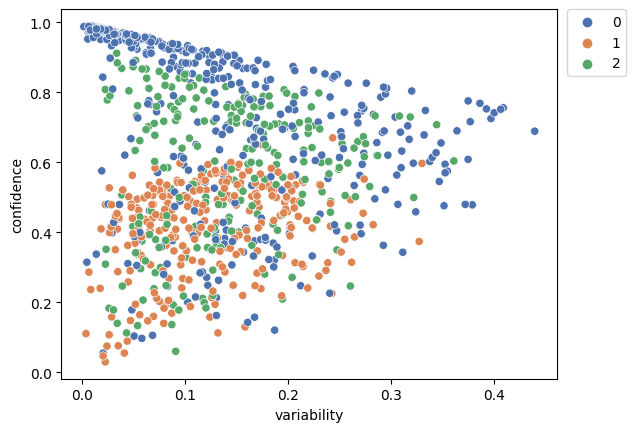

In [81]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='pred', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

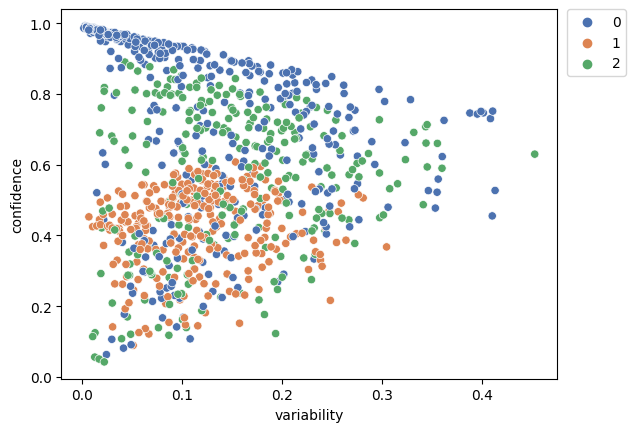

In [82]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='label', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

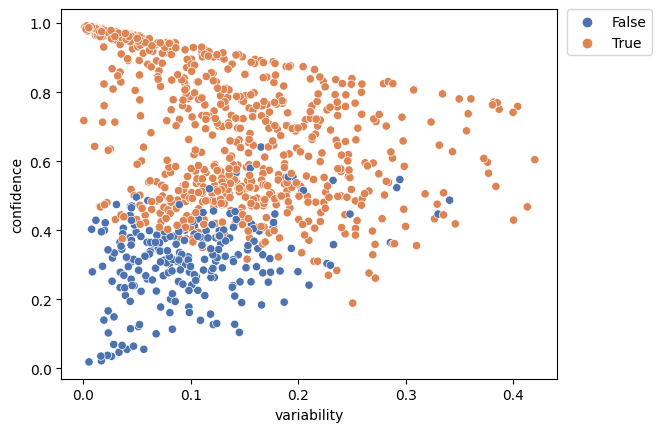

In [83]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='is_correct', palette='deep')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

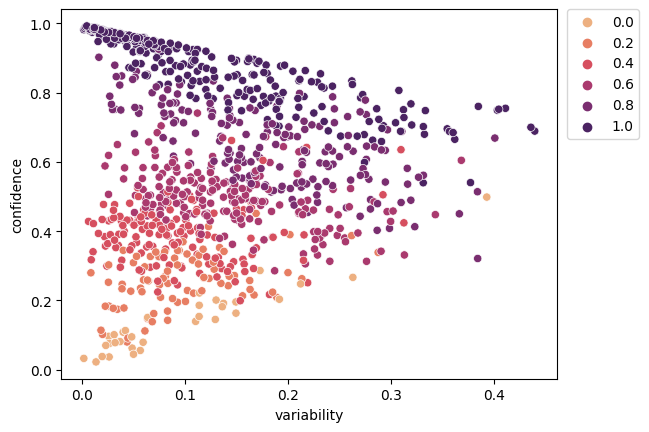

In [84]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='correctness', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

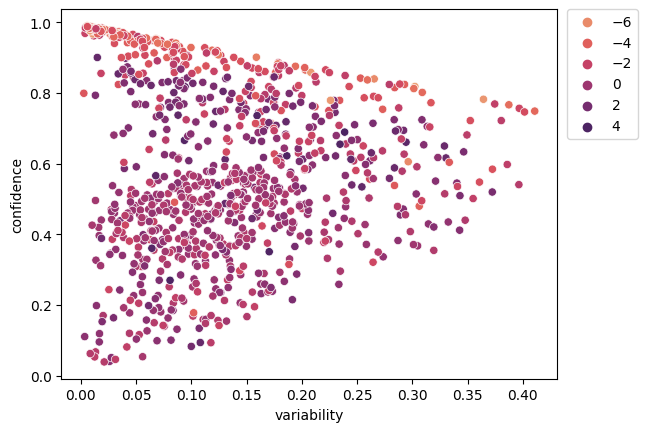

In [85]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.03), x="variability", y="confidence", hue='hate_speech_score', palette='flare')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

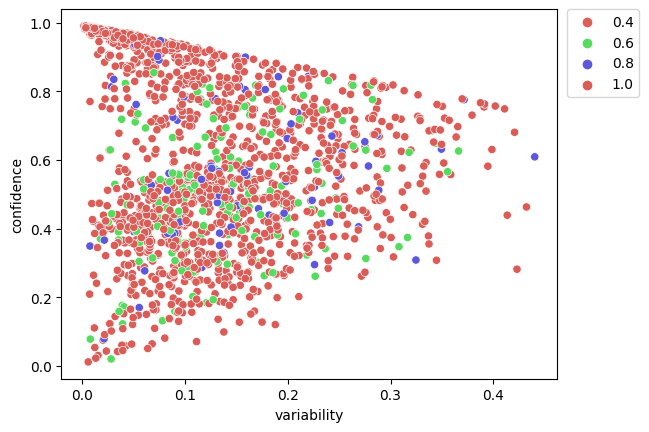

In [86]:
sns.scatterplot(data=train_values_agg_df.sample(frac=0.05), x="variability", y="confidence", hue='annotator_agreement_factor', palette='hls')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

<Axes: >

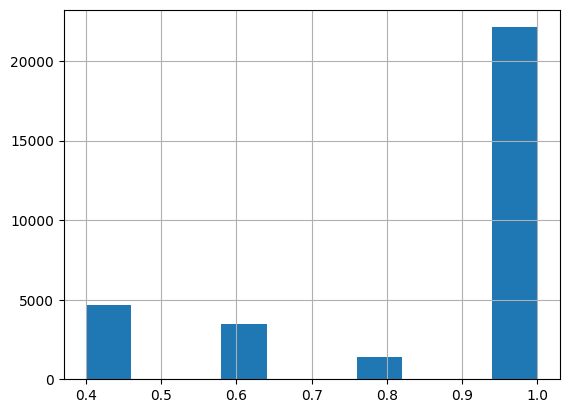

In [87]:
train_values_agg_df['annotator_agreement_factor'].hist()